In [ ]:
!gdown "1pv6YiFFuQ8VtJIvZyZKTtwqbF74GxniI"

Downloading...
From: https://drive.google.com/uc?id=1pv6YiFFuQ8VtJIvZyZKTtwqbF74GxniI
To: /content/sample_data_for_user_663960.csv
100% 12.1M/12.1M [00:00<00:00, 214MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from datetime import datetime
import pytz
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
dataset = pd.read_csv('sample_data_for_user_663960.csv')

In [ ]:
dataset = dataset[['rcvdTm','sloc']]

In [ ]:
def date_time_transform(data):
  return data[11:21] + " " + data[22:-3]

In [ ]:
dataset['date_time'] = dataset['rcvdTm'].transform(date_time_transform)

In [ ]:
dataset['date_time'] = pd.to_datetime(dataset['date_time'])

In [ ]:
size = len(dataset)
size

38846

In [ ]:
df = pd.DataFrame()

df['customerLocationState'] = ''
df['startTime'] = ''
df['endTime'] = ''
df['duration'] = ''

In [ ]:
startDate = dataset['date_time'][0]

for ind in range(1,size):
    if  dataset['sloc'][ind] != dataset['sloc'][ind-1]:
        tup = {'customerLocationState' : dataset['sloc'][ind-1],'startTime':startDate,'endTime':dataset['date_time'][ind-1] , 'duration': startDate - dataset['date_time'][ind-1]  }
        startDate = dataset['date_time'][ind-1]
        df1 = pd.DataFrame(tup, index=[0])
        df = pd.concat([df,df1],ignore_index = True)
        df.reset_index()

In [ ]:
df['customerLocationState']=df.customerLocationState.str.replace('Hallway','Bigroom' ).replace('Livingroom','Bigroom')

In [ ]:
df.head(10)

,customerLocationState,startTime,endTime,duration
0,Bedroom,2021-08-31 23:39:33,2021-08-31 21:46:05,0 days 01:53:28
1,Bigroom,2021-08-31 21:46:05,2021-08-31 21:40:46,0 days 00:05:19
2,Bedroom,2021-08-31 21:40:46,2021-08-31 21:39:59,0 days 00:00:47
3,Bigroom,2021-08-31 21:39:59,2021-08-31 21:39:45,0 days 00:00:14
4,Stairs,2021-08-31 21:39:45,2021-08-31 21:38:29,0 days 00:01:16
5,Bigroom,2021-08-31 21:38:29,2021-08-31 21:37:36,0 days 00:00:53
6,Stairs,2021-08-31 21:37:36,2021-08-31 21:37:13,0 days 00:00:23
7,Kitchen,2021-08-31 21:37:13,2021-08-31 21:37:06,0 days 00:00:07
8,Bigroom,2021-08-31 21:37:06,2021-08-31 21:35:34,0 days 00:01:32
9,Kitchen,2021-08-31 21:35:34,2021-08-31 21:35:17,0 days 00:00:17


# Data Preprocessing for modelling

extracting useful features

In [ ]:
le=LabelEncoder()
df['Location'] = le.fit_transform(df['customerLocationState'])
df['durationMinutes'] = df['duration'].dt.total_seconds()/60
df['DateStart'] = pd.to_datetime(df['startTime']).dt.date
df['YearStart'] = pd.to_datetime(df['startTime']).dt.year
df['MonthStart'] = pd.to_datetime(df['startTime']).dt.month
df['weekStart'] = pd.to_datetime(df['startTime']).dt.week
df['DayStart'] = pd.to_datetime(df['startTime']).dt.day
df['WeekYear'] = df['startTime'].apply(lambda x: "%d/%d" % (x.week, x.year))
df['MonthYear'] = df['startTime'].apply(lambda x: "%d/%d" % (x.month, x.year))

df['Dayofweekencoded'] = pd.to_datetime(df['startTime']).dt.dayofweek
df['Dayofweeknames'] = pd.to_datetime(df['startTime']).dt.day_name()
df['TimeStart'] = pd.to_datetime(df['startTime']).dt.time
df['hourStart'] = pd.to_datetime(df['startTime']).dt.hour
df['hourend'] = pd.to_datetime(df['endTime']).dt.hour
df['hourdiff'] = df['hourend']-df['hourStart']

df = df.sort_values(by='startTime',ascending=True)
df['total_freqbyday'] = df.groupby(['DateStart','customerLocationState'])['customerLocationState'].transform('count')
df['freq_cumbyday'] = df.groupby(['DateStart','customerLocationState'])['customerLocationState'].cumcount()+1
df['freq_cumbyHourofDay'] = df.groupby(['DateStart','customerLocationState','hourStart'])['customerLocationState'].cumcount()+1
df['freq_totalbyHourofDay'] = df.groupby(['DateStart','customerLocationState','hourStart'])['customerLocationState'].transform('count')
df['duration_cumusumbyday'] = df.groupby(['DateStart','customerLocationState'])['durationMinutes'].apply(lambda x: x.cumsum())
df['cumdurationlocationHourofDay'] = df.groupby(['DateStart','customerLocationState','hourStart'])['durationMinutes'].cumsum()
df['duration_totalsumbyday'] = df.groupby(['DateStart','customerLocationState'])['durationMinutes'].transform('sum')
df['event']= np.where((df['customerLocationState']!=df['customerLocationState'].shift())
                      ,df['customerLocationState'].shift()+'to'+df['customerLocationState'],'nochange')
df['Event_cumusumbyHourday'] = df.groupby(['DateStart','customerLocationState','event','hourStart'])['event'].cumcount()+1
df['Event_cumusumbyday'] = df.groupby(['DateStart','customerLocationState','event'])['event'].cumcount()+1

la=LabelEncoder()
df=df.dropna()
df=df.drop_duplicates()
df['eventcoded'] = la.fit_transform(df['event'])
df.columns.values

array(['customerLocationState', 'startTime', 'endTime', 'duration',
       'Location', 'durationMinutes', 'DateStart', 'YearStart',
       'MonthStart', 'weekStart', 'DayStart', 'WeekYear', 'MonthYear',
       'Dayofweekencoded', 'Dayofweeknames', 'TimeStart', 'hourStart',
       'hourend', 'hourdiff', 'total_freqbyday', 'freq_cumbyday',
       'freq_cumbyHourofDay', 'freq_totalbyHourofDay',
       'duration_cumusumbyday', 'cumdurationlocationHourofDay',
       'duration_totalsumbyday', 'event', 'Event_cumusumbyHourday',
       'Event_cumusumbyday', 'eventcoded'], dtype=object)

# Feature Selection & EDA for Feature Engineering

<Axes: >

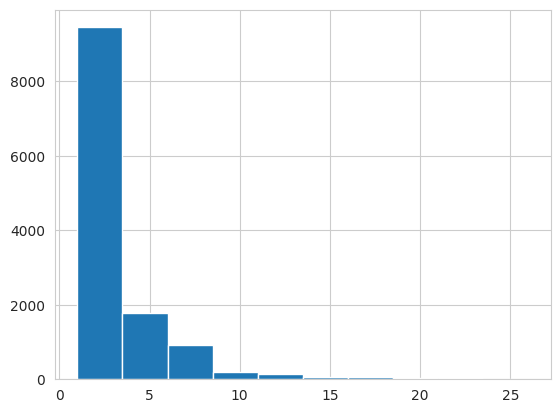

In [ ]:
df.freq_cumbyHourofDay.hist()

<Axes: ylabel='Density'>

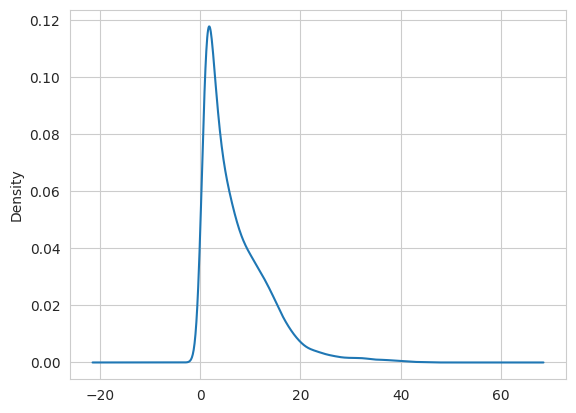

In [ ]:
df.Event_cumusumbyday.plot(kind='kde')

<Axes: xlabel='hourStart', ylabel='freq_cumbyHourofDay'>

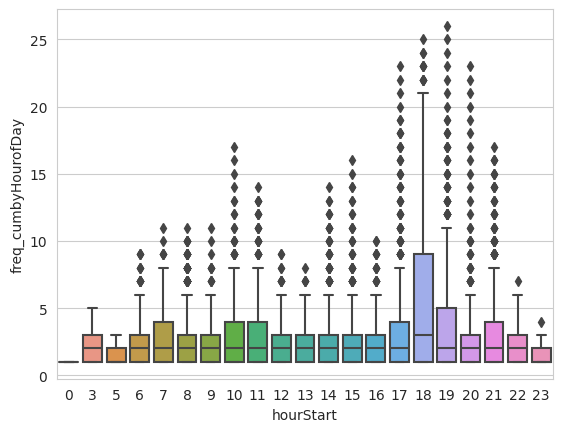

In [ ]:
import seaborn as sns
sns.set_style("whitegrid")

sns.boxplot(x = 'hourStart', y = 'freq_cumbyHourofDay', data = df)

In [ ]:
import plotly.express as px
fig = px.box(df, x='hourStart', y="Event_cumusumbyday",color="event")
fig.show()

In [ ]:
import plotly.express as px
fig = px.box(df, x='hourStart', y="freq_cumbyday",color="customerLocationState")
fig.show()

# PCA Analysis

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing

In [ ]:
pca = PCA(n_components=12)
datai= df[[
       'Location', 'durationMinutes',
       'MonthStart', 'weekStart', 'DayStart',
       'Dayofweekencoded', 'hourStart',
       'hourend', 'hourdiff', 'total_freqbyday', 'freq_cumbyday',
       'freq_cumbyHourofDay', 'freq_totalbyHourofDay',
       'duration_cumusumbyday', 'cumdurationlocationHourofDay',
       'duration_totalsumbyday',  'Event_cumusumbyHourday',
       'Event_cumusumbyday', 'eventcoded']]

datai=datai.dropna()
datai=datai.drop_duplicates()
scaler = preprocessing.StandardScaler()
scaler.fit(datai)
data=scaler.transform(datai)
pca.fit(datai)
print(pca.explained_variance_ratio_)

[8.44473507e-01 1.14340227e-01 2.89224187e-02 5.34046514e-03
 3.46714095e-03 1.43802589e-03 8.37769334e-04 6.33137070e-04
 1.35718728e-04 1.25157568e-04 1.07981756e-04 9.74168084e-05]


In [ ]:
# number of components
n_pcs= pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names =[
       'Location', 'durationMinutes',
       'MonthStart', 'weekStart', 'DayStart',
       'Dayofweekencoded', 'hourStart',
       'hourend', 'hourdiff', 'total_freqbyday', 'freq_cumbyday',
       'freq_cumbyHourofDay', 'freq_totalbyHourofDay',
       'duration_cumusumbyday', 'cumdurationlocationHourofDay',
       'duration_totalsumbyday',  'Event_cumusumbyHourday',
       'Event_cumusumbyday', 'eventcoded']

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

dfpca = pd.DataFrame(dic.items())
dfpca

,0,1
0,PC0,duration_totalsumbyday
1,PC1,duration_cumusumbyday
2,PC2,cumdurationlocationHourofDay
3,PC3,total_freqbyday
4,PC4,durationMinutes
5,PC5,eventcoded
6,PC6,freq_cumbyday
7,PC7,DayStart
8,PC8,hourStart
9,PC9,Event_cumusumbyday


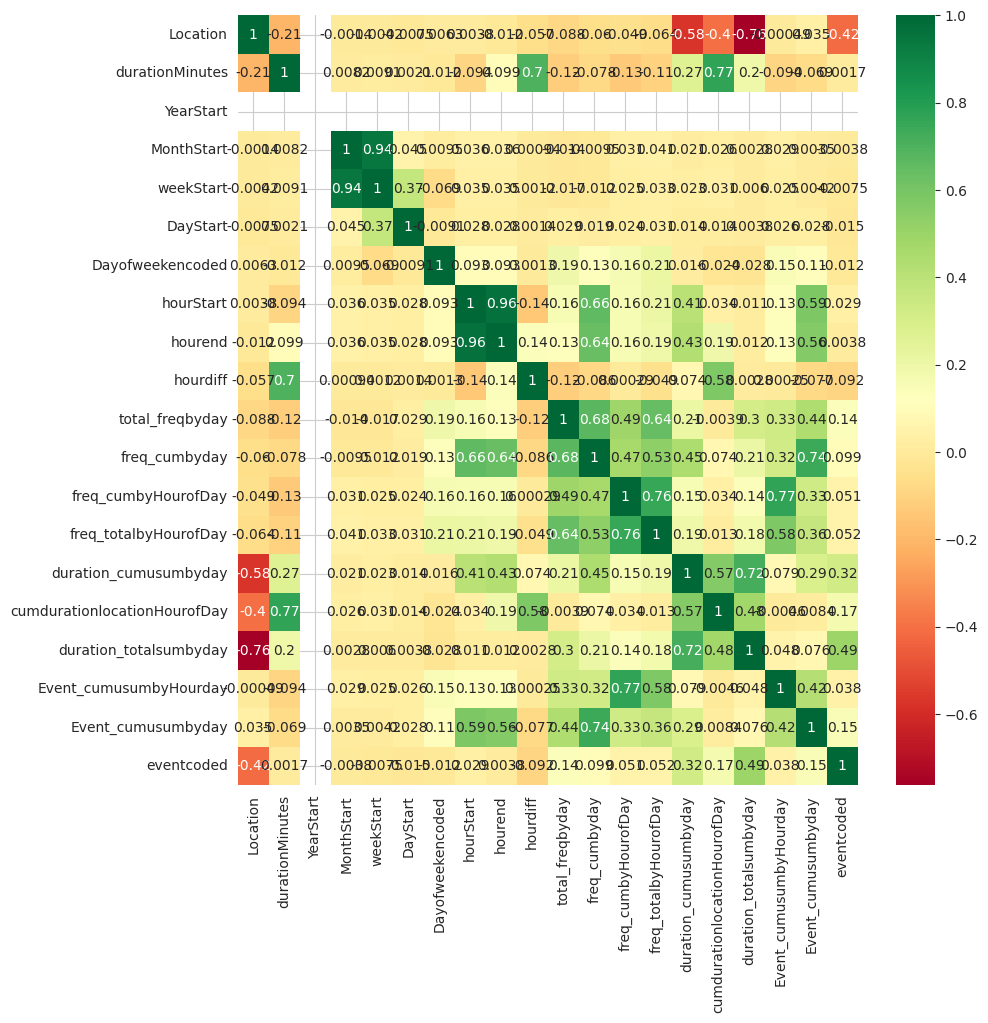

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))

g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# K means Clustering

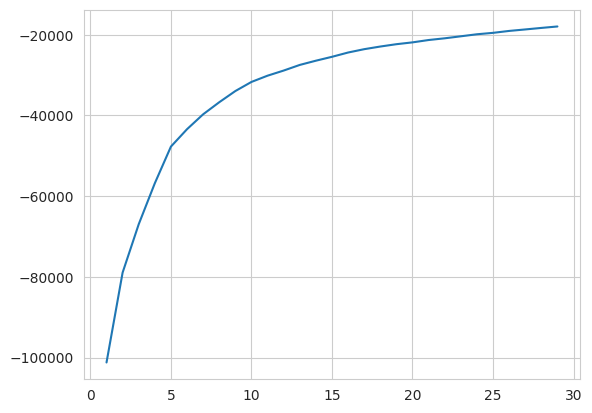

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

data = df[[
       'Location', 'durationMinutes','hourStart',
         'freq_cumbyday',
       'freq_cumbyHourofDay',
       'Event_cumusumbyHourday', 'Event_cumusumbyday' ,'eventcoded']]

scaler1 = preprocessing.StandardScaler()
np_scaled = scaler1.fit_transform(data)
data = pd.DataFrame(np_scaled)

min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

n_cluster = range(1, 30)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
#Silhouette score
from sklearn.metrics import silhouette_score
range_n_clusters = list (range(2,30))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(data)
    centers = clusterer.cluster_centers_

    score = silhouette_score(data, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.26987001530715216)
For n_clusters = 3, silhouette score is 0.21695899827003517)
For n_clusters = 4, silhouette score is 0.230194098432007)
For n_clusters = 5, silhouette score is 0.23633101584147329)
For n_clusters = 6, silhouette score is 0.23002688246109643)
For n_clusters = 7, silhouette score is 0.22644767741924993)
For n_clusters = 8, silhouette score is 0.2367444945300147)
For n_clusters = 9, silhouette score is 0.24287042298436087)
For n_clusters = 10, silhouette score is 0.2385930468989582)
For n_clusters = 11, silhouette score is 0.2317976263834436)
For n_clusters = 12, silhouette score is 0.2333162297533902)
For n_clusters = 13, silhouette score is 0.23782143313554988)
For n_clusters = 14, silhouette score is 0.23798700031505665)
For n_clusters = 15, silhouette score is 0.23720647546947934)
For n_clusters = 16, silhouette score is 0.23921710448063563)
For n_clusters = 17, silhouette score is 0.24330098190450578)
For n_clusters = 18, s

In [ ]:
km = KMeans(n_clusters=8)
km.fit(data)
km.predict(data)
df['cluster'] = km.predict(data)
df['principal_feature1'] = data[0]
df['principal_feature2'] = data[1]
df['cluster'].value_counts()

6    3047
2    2713
1    2515
3    2292
0     961
5     742
4     287
7      97
Name: cluster, dtype: int64

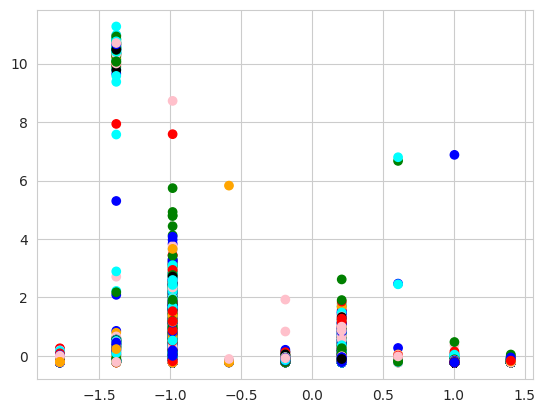

In [ ]:
#plot of different clusters with the 2 main features
fig, ax = plt.subplots()
colors = colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

As I can see here there are certain points which falls out of clusters

The underline assumption in the clustering based anomaly detection is that if we cluster the data, normal data will belong to clusters while anomalies will not belong to any clusters or belong to small clusters.

In [ ]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance

In [ ]:
outliers_fraction=0.005
distance = getDistanceByPoint(data, km)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

df['anomaly21'] = (distance >= threshold).astype(int)

In [ ]:
outliers_fraction=0.005
distance = getDistanceByPoint(data, km)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly21'] = (distance >= threshold).astype(int)

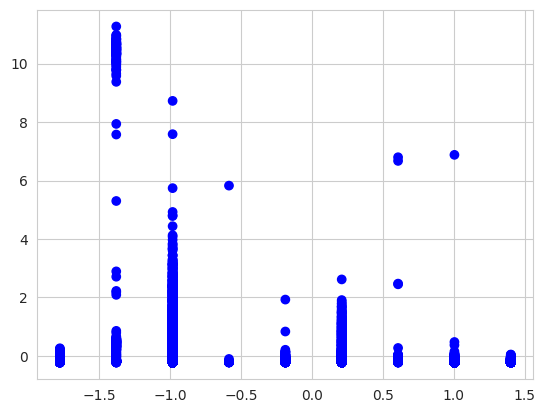

In [ ]:
df=df.dropna()
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

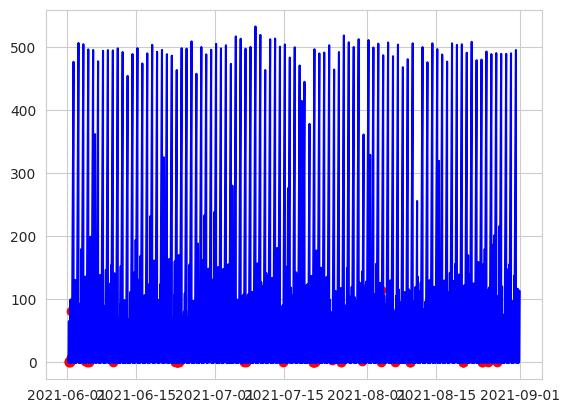

In [ ]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly21'] == 1, ['startTime', 'durationMinutes']] #anomaly

ax.plot(df['startTime'], df['durationMinutes'], color='blue')
ax.scatter(a['startTime'],a['durationMinutes'], color='red')
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='startTime', y="freq_totalbyHourofDay",color="anomaly21")
fig.show()

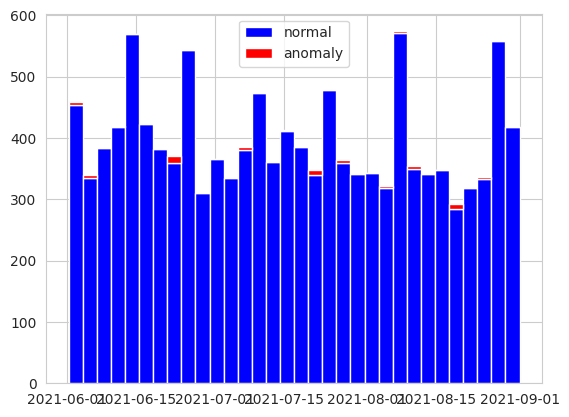

In [ ]:
a = df.loc[df['anomaly21'] == 0, 'startTime']
b = df.loc[df['anomaly21'] == 1, 'startTime']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

# Anomaly Detection using Gaussian Distribution

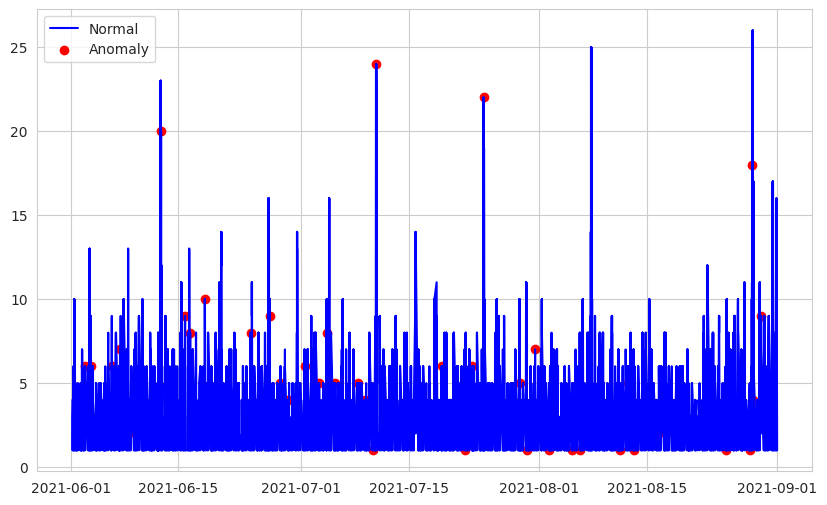

In [ ]:
from sklearn.covariance import EllipticEnvelope
envelope =  EllipticEnvelope(contamination = outliers_fraction)
envelope.fit(data)
df['anomaly22'] = pd.Series(envelope.predict(data))

fig, ax = plt.subplots(figsize=(10,6))
aellip = df.loc[df['anomaly22'] == -1, ['startTime', 'freq_totalbyHourofDay']]
ax.plot(df['startTime'], df['freq_totalbyHourofDay'], color='blue', label = 'Normal')
ax.scatter(aellip['startTime'],aellip['freq_totalbyHourofDay'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='startTime', y="freq_totalbyHourofDay",color="anomaly22")
fig.show()

# Local Outlier Factor

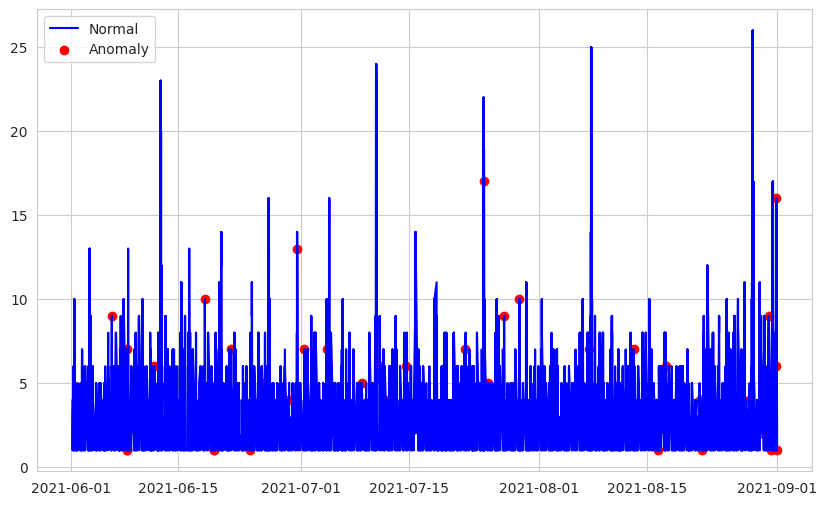

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
LocalOutlierFactor=  LocalOutlierFactor(contamination = outliers_fraction)
LocalOutlierFactor.fit(data)
df['anomaly23'] = pd.Series(LocalOutlierFactor.fit_predict(data))
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=(10,6))
aellip = df.loc[df['anomaly23'] == -1, ['startTime', 'freq_totalbyHourofDay']] #anomaly
ax.plot(df['startTime'], df['freq_totalbyHourofDay'], color='blue', label = 'Normal')
ax.scatter(aellip['startTime'],aellip['freq_totalbyHourofDay'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='startTime', y="freq_totalbyHourofDay",color="anomaly23")
fig.show()

# Isolation Forest

In [ ]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)

df['anomaly25'] = pd.Series(model.predict(data))
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )
print(df['anomaly25'].value_counts())

0    12590
1       64
Name: anomaly25, dtype: int64


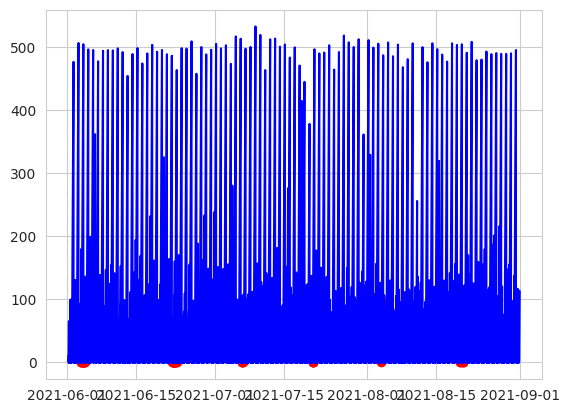

In [ ]:
fig, ax = plt.subplots()


a = df.loc[df['anomaly25'] == 1, ['startTime', 'durationMinutes']] #anomaly

ax.plot(df['startTime'], df['durationMinutes'], color='blue')
ax.scatter(a['startTime'],a['durationMinutes'], color='red')
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='startTime', y="freq_totalbyHourofDay",color="anomaly25")
fig.show()

# One class SVM

In [ ]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)

model =  OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)

df['anomaly26'] = pd.Series(model.predict(data))
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )
print(df['anomaly26'].value_counts())

0    12590
1       64
Name: anomaly26, dtype: int64


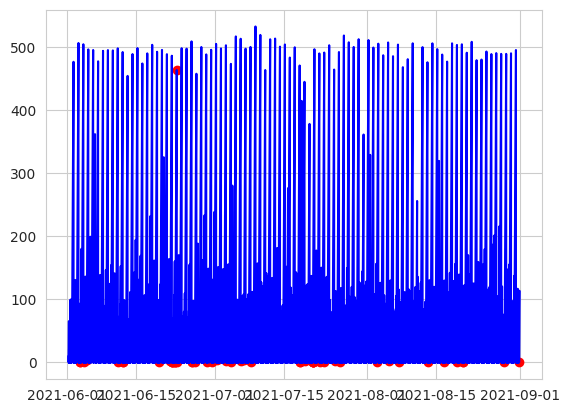

In [ ]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly26'] == 1, ['startTime', 'durationMinutes']]
ax.plot(df['startTime'], df['durationMinutes'], color='blue')
ax.scatter(a['startTime'],a['durationMinutes'], color='red')
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter(df, x='startTime', y="freq_totalbyHourofDay",color="anomaly26")
fig.show()

# Conclusion

-Some of our models really behave well .

-As we don't have any data related to any labaled anomaly we cannot check how accurately these models are performing

-As data is sequential in nature, LSTM may perform better than these models